### The Rain in Spain - the last 100 years

Data source: The data comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

In [39]:
!sudo chmod u+rwx /home/ubuntu/anaconda3

In [40]:
#!pip install pystan
!conda install -c conda-forge fbprophet -y

/bin/sh: 1: conda: Permission denied


In [2]:
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import mplleaflet

In [3]:
# countries and their codes
path='https://rain-in-spain-data.s3.us-east-2.amazonaws.com/'
ctry_df=pd.read_fwf(path+'ghcnd-countries.txt', widths=[2,1,46], header=None)
ctry_df.columns=['CODE','NO1','NAME']
ctry_df=ctry_df.drop(columns='NO1')
# metadata for all stations
meta_df = pd.read_fwf(path+'ghcnd-stations.txt', widths=[11,1,8,1,9,1,6,1,2,1,30,1,3,1,3,1,5], header=None)
meta_df.columns = ['ID','NO1','LATITUDE','NO2','LONGITUDE','NO3','ELEVATION','NO4','STATE','NO5','NAME',
            'NO6','GSN FLAG','NO7','HCN/CRN FLAG','NO8','WMO ID']
meta_df = meta_df.drop(columns=['NO1','NO2','NO3','NO4','NO5','NO6','NO7','NO8'])
meta_df['COUNTRY']=[row[:2] for row in meta_df.ID]
# only stations for Spain
ctry_code='SP'
meta_df = meta_df[meta_df.COUNTRY==ctry_code]
print(f'Number of stations in {ctry_df[ctry_df.CODE==ctry_code].NAME.item()}: {len(meta_df)}')
meta_df.head()

Number of stations in Spain: 207


,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID,COUNTRY
49802,SP000003195,40.4117,-3.6781,667.0,NaN,MADRID - RETIRO,NaN,NaN,8222.0,SP
49803,SP000004452,38.8831,-6.8292,185.0,NaN,BADAJOZ/TALAVERA LA REAL,NaN,NaN,8330.0,SP
49804,SP000006155,36.6667,-4.4881,7.0,NaN,MALAGA AEROPUERTO,NaN,NaN,8482.0,SP
49805,SP000007038,37.9769,0.7106,1.0,NaN,TORREVIEJA,NaN,NaN,8433.0,SP
49806,SP000008027,43.3075,-2.0392,251.0,NaN,SAN SEBASTIAN - IGUELDO,GSN,NaN,8027.0,SP


In [4]:
def leaflet_plot_stations(df):
    "Map of stations in Spain"
    lats, lons = df.LATITUDE.tolist(), df.LONGITUDE.tolist()
    plt.figure(figsize=(8,8))
    plt.scatter(lons, lats, c='r', alpha=0.7, s=20)
    return mplleaflet.display()

In [5]:
leaflet_plot_stations(meta_df)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [6]:
# select weather station
stations=[*zip(meta_df.NAME,meta_df.ID)]
w=widgets.Dropdown(
    options=stations[:500],
    value=stations[0][1],
    description='Station:',
    disabled=False,
)

In [7]:
def on_change_stn(change):
    "Code changed from default"
    if change['type'] == 'change' and change['name'] == 'value':
        print (f"station code {change['new']}")

In [8]:
w.observe(on_change_stn)
display(w)

Dropdown(description='Station:', options=(('MADRID - RETIRO', 'SP000003195'), ('BADAJOZ/TALAVERA LA REAL', 'SP…

In [9]:
def gen_col_names(lst):
    "select columns of interest"
    for i in range(31):
        lst=lst+['VALUE'+str(i+1),'MFLAG'+str(i+1),'QFLAG'+str(i+1),'SFLAG'+str(i+1)]
    return lst

In [10]:
def gen_drop_col_names(lst):
    "drop columns of no interest"
    for i in range(31):
        lst=lst+['MFLAG'+str(i+1),'QFLAG'+str(i+1),'SFLAG'+str(i+1)]
    return lst

In [11]:
# rainfall data for a single station
# PRCP = Precipitation (tenths of mm)
station=w.value
print('Daily',meta_df[meta_df.ID==station].NAME.item())
df = pd.read_fwf(path+'SP_dly/'+station+'.dly', widths=[11,4,2,4,]+[5,1,1,1]*31, header=None)
df.columns=gen_col_names(['ID','YEAR','MONTH','ELEMENT'])
df=df[df.ELEMENT=='PRCP'].drop(columns=gen_drop_col_names(['ID','ELEMENT']))
df=df.melt(['YEAR','MONTH']).sort_values(['YEAR','MONTH']).reset_index(drop=True)
df=df[df.value>-9999]
df['variable'] = [row[5:] for row in df.variable]
df['date']=pd.to_datetime(df[['YEAR', 'MONTH', 'variable']].rename(columns={'YEAR': 'year', 'MONTH': 'month', 'variable': 'day'}))
df=df.drop(columns=['YEAR','MONTH','variable']).rename(columns={'value':'PRECP'})
df.set_index('date', inplace=True)
df.tail()

Daily MADRID - RETIRO


,PRECP
date,
2020-07-22,53
2020-07-23,0
2020-08-10,3
2020-08-11,23
2020-08-12,325


In [12]:
mthly_df=df.resample('MS').sum()
print ('Monthly')
mthly_df.head()

Monthly


,PRECP
date,
1920-01-01,28
1920-02-01,894
1920-03-01,301
1920-04-01,263
1920-05-01,753


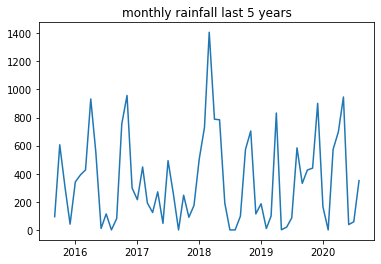

In [13]:
plt.plot(mthly_df.index[-60:],mthly_df.PRECP[-60:])
plt.title('monthly rainfall last 5 years');

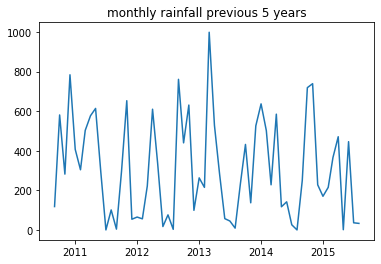

In [14]:
plt.plot(mthly_df.index[-120:-60],mthly_df.PRECP[-120:-60])
plt.title('monthly rainfall previous 5 years');

In [15]:
yrly_df=df.resample('YS').sum()
print ('Yearly')
yrly_df.head()

Yearly


,PRECP
date,
1920-01-01,4500
1921-01-01,2864
1922-01-01,3825
1923-01-01,3477
1924-01-01,3927


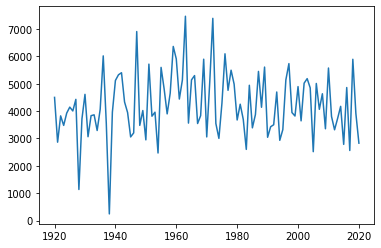

In [16]:
plt.plot(yrly_df.index,yrly_df.PRECP);

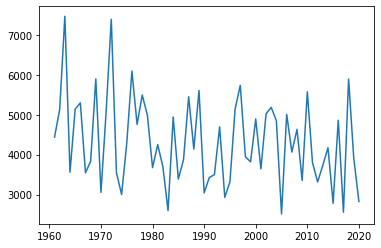

In [17]:
plt.plot(yrly_df.index[-60:],yrly_df.PRECP[-60:]);

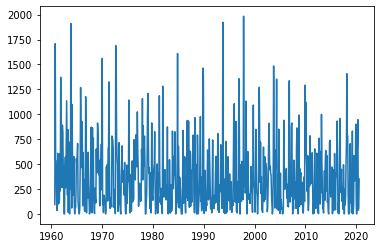

In [18]:
plt.plot(mthly_df.index[-60*12:],mthly_df.PRECP[-60*12:]);

In [19]:
qtly_df=df.resample('QS').sum()
qtly_df.head()

,PRECP
date,
1920-01-01,1223
1920-04-01,1174
1920-07-01,111
1920-10-01,1992
1921-01-01,853


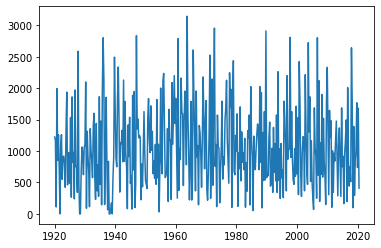

In [20]:
plt.plot(qtly_df.index,qtly_df.PRECP);

In [21]:
%load_ext watermark

In [22]:
%watermark --iversions -p matplotlib,mplleaflet,watermark,pylint

pandas     1.0.1
ipywidgets 7.5.1
matplotlib 3.1.3
mplleaflet 0.0.5
watermark 2.0.2
pylint 2.4.4


In [23]:
#!git add .
#!git commit -m 'updated notebook'

In [24]:
!jupyter nbconvert --to=script --output-dir=./tmp/converted-notebooks/ ./*.ipynb
!pylint ./tmp/converted-notebooks/rain_in_spain.py --disable=C,E0602,W0301,W0621

[NbConvertApp] Converting notebook ./rain_in_spain.ipynb to script
[NbConvertApp] Writing 4626 bytes to ./tmp/converted-notebooks/rain_in_spain.py

------------------------------------
Your code has been rated at 10.00/10

